In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table
import GCRCatalogs
from GCR import GCRQuery
import statistics
import os, sys
import healpy as hp
from tqdm.auto import tqdm, trange
import scipy.stats
import FoFCatalogMatching
import pandas as pd
from astropy.coordinates import SkyCoord
from scipy.stats import pearsonr
import warnings

In [2]:
warnings.filterwarnings('ignore')

### Z and mag filters :

In [3]:
# mag filters :

object_mag_filters = ['mag_i_cModel < 26.5', 'mag_i_cModel > 18',
    (np.isfinite, 'mag_i_cModel'), (np.isfinite, 'mag_r_cModel'), (np.isfinite, 'mag_z_cModel')]

truth_mag_filters = ['mag_i<28','mag_i>18',(np.isfinite, 'mag_i'), (np.isfinite, 'mag_r'), (np.isfinite, 'mag_z')]

# z filters (grande):

object_z_filters = ['photoz_mean < 1.5', (np.isfinite, 'photoz_mean')]

truth_z_filters = ['redshift < 1.5', (np.isfinite, 'redshift')] 

### CosmoDC2 and DC2Objects (truth and object) :

In [4]:
cosmodc2 = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image') #truth catalog
dc2 = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_with_addons') #object catalog

In [5]:
cosmodc2.get_quantity_info('is_central')

In [6]:
#data object catalog :

object_quantities = ['ra', 'dec', 'mag_i_cModel', 'photoz_mean']

object_data = (dc2.get_quantities(object_quantities,
                                 filters=['extendedness>0', 'clean']+object_mag_filters+object_z_filters,
                                 native_filters=['tract==4026']))

print(type(object_data))

<class 'dict'>


In [7]:
# data truth catalog :

eps = 10/3600 # 10 arcsec
max_ra = np.nanmax(object_data['ra']) + eps
min_ra = np.nanmin(object_data['ra']) - eps
max_dec = np.nanmax(object_data['dec']) + eps
min_dec = np.nanmin(object_data['dec']) - eps
pos_filters = [f'ra >= {min_ra}',f'ra <= {max_ra}', f'dec >= {min_dec}', f'dec <= {max_dec}']

vertices = hp.ang2vec(np.array([min_ra, max_ra, max_ra, min_ra]),
                      np.array([min_dec, min_dec, max_dec, max_dec]), lonlat=True)
ipix = hp.query_polygon(32, vertices, inclusive=True)
healpix_filter = GCRQuery((lambda h: np.isin(h, ipix, True), "healpix_pixel"))

In [8]:
truth_quantities = ['galaxy_id', 'ra', 'dec', 'mag_i', 'redshift', 'is_central', 'halo_mass', 'halo_id']

truth_data = (cosmodc2.get_quantities(truth_quantities, 
                                      filters=truth_mag_filters+pos_filters+truth_z_filters, 
                                      native_filters=healpix_filter))

In [9]:
list(truth_data)

['halo_id',
 'dec',
 'ra',
 'galaxy_id',
 'halo_mass',
 'mag_i',
 'is_central',
 'redshift']

In [10]:
truth_data['halo_mass']

array([5.07006249e+12, 5.07006249e+12, 3.79915201e+10, ...,
       1.28993621e+10, 4.89915741e+10, 2.66634575e+10])

In [11]:
print("nombre de galaxies =", len(truth_data['ra']))
print("nombre de galaxies centrales =", len(np.where(truth_data['is_central']==True)[0]))
print("pourcentage de galaxies centrales =", (len(np.where(truth_data['is_central']==True)[0])/len(truth_data['ra']))*100, '%')
print("nombre d'objets =", len(object_data['ra']))

nombre de galaxies = 2038017
nombre de galaxies centrales = 1884055
pourcentage de galaxies centrales = 92.44549971859901 %
nombre d'objets = 560402


In [12]:
truth_data['mag_i'][np.where(truth_data['is_central']==True)[0]]

array([23.95609176, 27.467791  , 23.78634715, ..., 27.68831722,
       27.19187752, 27.58106806])

(array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07]),
 [Text(0, 1.0, '$\\mathdefault{10^{0}}$'),
  Text(0, 10.0, '$\\mathdefault{10^{1}}$'),
  Text(0, 100.0, '$\\mathdefault{10^{2}}$'),
  Text(0, 1000.0, '$\\mathdefault{10^{3}}$'),
  Text(0, 10000.0, '$\\mathdefault{10^{4}}$'),
  Text(0, 100000.0, '$\\mathdefault{10^{5}}$'),
  Text(0, 1000000.0, '$\\mathdefault{10^{6}}$'),
  Text(0, 10000000.0, '$\\mathdefault{10^{7}}$')])

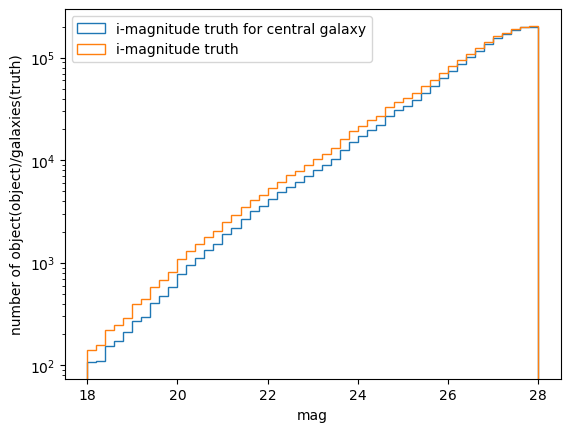

In [13]:
plt.figure()
truth_hist_central=plt.hist(truth_data['mag_i'][np.where(truth_data['is_central']==True)[0]], bins=50, 
                            histtype='step', label='i-magnitude truth for central galaxy', log=True)
truth_hist=plt.hist(truth_data['mag_i'], bins=50, histtype='step', label='i-magnitude truth', log=True)
plt.legend()
plt.xlabel('mag')
plt.ylabel('number of object(object)/galaxies(truth)')
plt.xticks()
plt.yticks()

(array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06,
        1.e+07]),
 [Text(0, 0.1, '$\\mathdefault{10^{-1}}$'),
  Text(0, 1.0, '$\\mathdefault{10^{0}}$'),
  Text(0, 10.0, '$\\mathdefault{10^{1}}$'),
  Text(0, 100.0, '$\\mathdefault{10^{2}}$'),
  Text(0, 1000.0, '$\\mathdefault{10^{3}}$'),
  Text(0, 10000.0, '$\\mathdefault{10^{4}}$'),
  Text(0, 100000.0, '$\\mathdefault{10^{5}}$'),
  Text(0, 1000000.0, '$\\mathdefault{10^{6}}$'),
  Text(0, 10000000.0, '$\\mathdefault{10^{7}}$')])

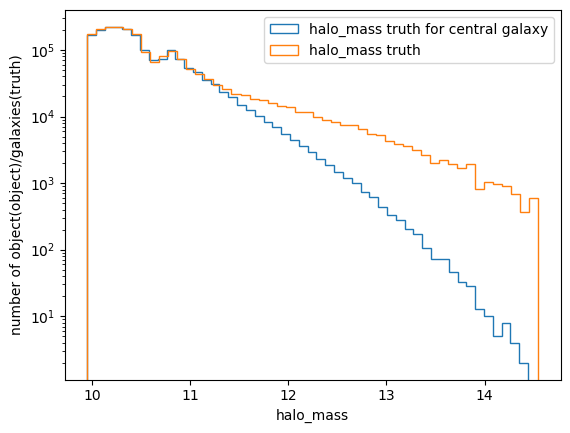

In [14]:
plt.figure()
truth_hist_central=plt.hist(np.log10(truth_data['halo_mass'])[np.where(truth_data['is_central']==True)[0]], bins=50, 
                            histtype='step', label='halo_mass truth for central galaxy', log=True)
truth_hist=plt.hist(np.log10(truth_data['halo_mass']), bins=50, histtype='step', label='halo_mass truth', log=True)
plt.legend()
plt.xlabel('halo_mass')
plt.ylabel('number of object(object)/galaxies(truth)')
plt.xticks()
plt.yticks()

In [15]:
indice=np.where(truth_data['is_central']==True)[0]
redshift=truth_data['redshift']
halo_mass=truth_data['halo_mass']
mag_i=truth_data['mag_i']
galaxy_id=truth_data['galaxy_id']
is_central=truth_data['is_central']

In [16]:
len(redshift[indice])

1884055

In [17]:
list(truth_data)

['halo_id',
 'dec',
 'ra',
 'galaxy_id',
 'halo_mass',
 'mag_i',
 'is_central',
 'redshift']

### FoF algo :

In [18]:
my_linking_length = 0.4 #linking_lenghts in arcseconds optimal, for 18<mag<26.5

In [19]:
results = FoFCatalogMatching.match(catalog_dict={'object':pd.DataFrame(object_data), 
                                                 'galaxy':pd.DataFrame(truth_data)},
                                                    linking_lengths=my_linking_length)

In [51]:
results

row_index,catalog_key,group_id
int64,str6,int64
0,object,0
1887873,galaxy,0
1,object,1
488379,galaxy,1
2,object,2
485145,galaxy,2
3,object,3
640537,galaxy,3
4,object,4


In [50]:
len(results)

2598419

Text(0.5, 1.0, 'Histogram of galaxy grouping by FoF algorithm ')

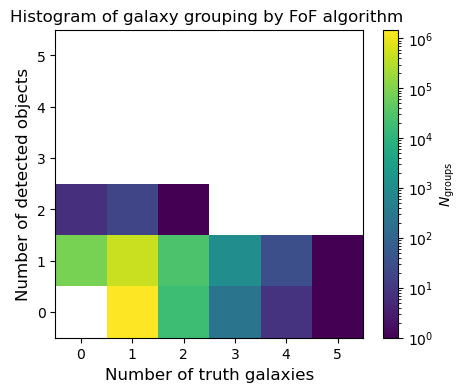

In [34]:
# first we need to know which rows are from the truth catalog and which are from the object
truth_mask = results['catalog_key'] == 'galaxy'
object_mask = ~truth_mask

# np.bincount will give up the number of id occurrences (like histogram but with integer input)
n_groups = results['group_id'].max() + 1   #obtenu grâce au FoF algo
n_truth = np.bincount(results['group_id'][truth_mask], minlength=n_groups)  # groupe de galaxies
n_object = np.bincount(results['group_id'][object_mask], minlength=n_groups)  # groupe d'objets

plt.figure(figsize=(11,4))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(121)
hist1=plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm())
plt.xlabel('Number of truth galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of galaxy grouping by FoF algorithm ')

plt2=plt.subplot(122)


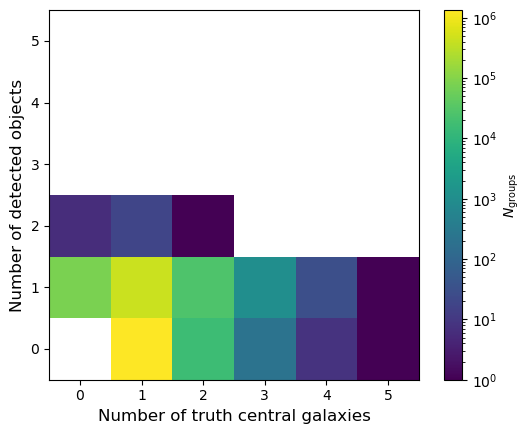

In [45]:
n_truth_central = np.bincount(results['group_id'][truth_mask], minlength=n_groups)  # groupe de galaxies centrales

plt.figure()
hist2=plt.hist2d(n_truth[np.where(truth_data['is_central']==True)[0]], n_object[np.where(truth_data['is_central']==True)[0]],
                    bins=np.arange(max(np.max(n_object), 
                    np.max(n_truth))+2)-0.5, 
                    norm=mpl.colors.LogNorm())
plt.xlabel('Number of truth central galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.show()

In [48]:
n_truth

array([1, 1, 1, ..., 1, 1, 1])

In [39]:
 len(n_object[np.where(truth_data['is_central']==True)[0]])

1884055

In [42]:
hist2

(array([[0.000000e+00, 7.801700e+04, 6.000000e+00, 0.000000e+00,
         0.000000e+00, 0.000000e+00],
        [1.339593e+06, 4.233360e+05, 1.800000e+01, 0.000000e+00,
         0.000000e+00, 0.000000e+00],
        [1.606700e+04, 2.574200e+04, 1.000000e+00, 0.000000e+00,
         0.000000e+00, 0.000000e+00],
        [2.200000e+02, 1.015000e+03, 0.000000e+00, 0.000000e+00,
         0.000000e+00, 0.000000e+00],
        [8.000000e+00, 3.000000e+01, 0.000000e+00, 0.000000e+00,
         0.000000e+00, 0.000000e+00],
        [1.000000e+00, 1.000000e+00, 0.000000e+00, 0.000000e+00,
         0.000000e+00, 0.000000e+00]]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 <matplotlib.collections.QuadMesh at 0x7f0c59f8cf70>)